In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import *
from scipy.misc import imread
import numpy as np

In [2]:
xx=np.load('xx.npy')
yy=np.load('yy.npy')
Lambda=np.load('Lambda.npy')
k_z_values=np.load('k_z_values.npy')
kernel_in=np.load('opkernel_trained.npy')
kernel_op = tf.constant(kernel_in)
f = tf.constant(0.3E-2)
x_tensor = tf.constant(xx, tf.float32)
y_tensor = tf.constant(yy, tf.float32)
Lambda_tensor = tf.constant(Lambda, tf.float32)
k_z = tf.constant(k_z_values, tf.complex64)
# Input image (CAN TAKE ANY BATCH SIZE BUT SET THE BATCH SIZE VARIABLE BELOW EQUAL TO THIS NUMBER)
batch_size = 1 # PLEASE SET THIS NUMBER TO THE BATCH SIZE THAT YOU PLAN TO USE
im1 = (imread("poodle.png")[:,:,:3]).astype(float32)
im1 = im1 - mean(im1)
input_image = zeros((1, 227, 227, 3))
input_image[0, :, :, :] = im1
# input_image[1, :, :, :] = im1
image = tf.placeholder(tf.complex64, shape = (1, 227, 227, 3))
img = tf.placeholder(tf.float32, shape = (1, 227, 227, 3))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


In [3]:
def sqnlconv(input, kernel, k_h, k_w, c_o, s_h, s_w,  padding="VALID"):

    kernel_R = tf.reshape(kernel[:,:,0,:], shape = (11,11,1,96))
    kernel_G = tf.reshape(kernel[:,:,1,:], shape = (11,11,1,96))
    kernel_B = tf.reshape(kernel[:,:,2,:], shape = (11,11,1,96))
    convolve = lambda i, k: tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding=padding)
    conv1 = convolve(tf.reshape(input[:,:,:,0], shape = (1,227,227,1)), kernel_R)
    conv2 = convolve(tf.reshape(input[:,:,:,1], shape = (1,227,227,1)), kernel_G)
    conv3 = convolve(tf.reshape(input[:,:,:,2], shape = (1,227,227,1)), kernel_B)
    conv = tf.add(tf.add(conv1**2, conv2**2), conv3**2)
    return  conv

In [4]:
k_h = 11; k_w = 11; c_o = 96; s_h = 1; s_w = 1
net_data = load("bvlc_alexnet.npy",encoding="latin1").item()
kernel_net = net_data["conv1"][0]
kernel_alex=tf.constant(kernel_net)
conv1 = sqnlconv(img, kernel_alex, k_h, k_w, c_o, s_h, s_w, padding="SAME")

In [5]:
def fftshift_tf(data):
    
    dims = tf.shape(data)
    num = dims[3]
    shiftAmt = (num - 1) / 2
    shiftAmt = tf.cast(shiftAmt, int32)
    output = tf.manip.roll(data, shift=shiftAmt, axis=2)
    output = tf.manip.roll(output, shift=shiftAmt, axis=3)
    
    return output

# Performs an ifftshift operation on the last two dimensions of a 4-D input tensor
def ifftshift_tf(data):
    
    dims = tf.shape(data)
    num = dims[3]
    shiftAmt = (num + 1) / 2
    shiftAmt = tf.cast(shiftAmt, int32)
    output = tf.manip.roll(data, shift=shiftAmt, axis=2)
    output = tf.manip.roll(output, shift=shiftAmt, axis=3)
    
    return output


# Generates the phase for a lens based on the focal length variable "f". Other referenced variables are global
def generate_phase():
    
    phase = tf.constant(2*pi, tf.float32) / Lambda * (tf.sqrt(tf.square(x_tensor) + tf.square(y_tensor) + tf.square(f)) - f)
    phase = tf.cast(phase, tf.complex64)
    return phase

# Generates the Fourier space propagator based on the focal length variable "f". Other referenced variables are global
def generate_propagator():
    
    propagator = tf.exp(1j * k_z * tf.cast(f, tf.complex64))
    propagator = ifftshift_tf(propagator)
    
    return propagator

# Propagate an input E-field distribution along the optical axis using the defined propagator
def propagate(input_field, propagator):
    
    # Propagate using tensorflow
    output = tf.ifft2d(tf.fft2d(input_field) * propagator)
    
    return output

# Pass an image through a 4f system
def simulate_4f_system(input_field, kernel):
    
    # Calculate the lens phase
    lens_phase = generate_phase()
    
    # Calculate the propagator
    propagator = generate_propagator()
    
    # Propagate up to the first lens
    before_L1 = propagate(input_field, propagator)
    
    # Apply lens1 and propagate to the filter plane
    before_kernel = propagate(before_L1 * tf.keras.backend.exp(-1j * lens_phase), propagator)
    
    # Apply kernel and propagate to the second lens
    before_L2 = propagate(before_kernel * kernel, propagator)
    
    # Apply lens2 and propagate to the output plane
    output = propagate(before_L2 * tf.keras.backend.exp(-1j * lens_phase), propagator)
    
    # Return output of the 4f optical convolution
    return output

    
def convolve_with_all_kernels(image, kernels, name): 

    # Zero pad the kernels for subsequent Fourier processing    
    kernels = tf.concat([kernels, tf.constant(zeros((11, 216, 3, 96)), tf.float32)], axis=1)
    kernels = tf.concat([kernels, tf.constant(zeros((216, 227, 3, 96)), tf.float32)], axis=0)
    
    # Align the kernels for Fourier transforming
    kernels = tf.transpose(kernels, perm=[3, 2, 0, 1])
    kernels = tf.cast(kernels, tf.complex64)
    kernels = tf.fft2d(kernels)
    kernels = ifftshift_tf(kernels)
    
    # Add an extra dimension for the batch size and duplicate the kernels to apply equally to all images in the batch
    kernels = tf.expand_dims(kernels, axis=0)
    kernels = tf.tile(kernels, multiples=[batch_size, 1, 1, 1, 1])
    
    # Add a dimension to the input image tensor to enable convolution with all 96 first layer kernels
    image = tf.cast(image,tf.complex64)
    image = tf.expand_dims(image, axis=1)
    image = tf.transpose(image, perm=[0, 1, 4, 2, 3])
    image = tf.tile(image, multiples=[1, 96, 1, 1, 1])
    
    # Simulate the 4f system output for all 96 kernels for all color channels and sum the channel outputs
    output = tf.reduce_sum(tf.abs(simulate_4f_system(image, kernels)) ** 2, axis=2)
    
    # Transpose and flip the output for display purposes
    output = tf.transpose(output, perm=[0, 2, 3, 1])
    output = tf.image.flip_left_right(output)
    output = tf.image.flip_up_down(output)
     
    # Convert to float format
    output = tf.cast(output, tf.float32)
    
    # Return the output
    return output

In [6]:
conv2 = convolve_with_all_kernels(image, kernel_op, 'op')

In [7]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())
conv = sess.run(conv1,feed_dict={img:input_image})
op =sess.run(conv2, feed_dict={image:input_image})

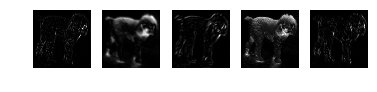

In [8]:
fig, ax = plt.subplots(1, 5)
for i in range(1,6):
    ax = plt.subplot(1,5,i)
    plt.imshow(conv[0, :, :, i+20], cmap = plt.cm.gray)
    plt.axis('off')

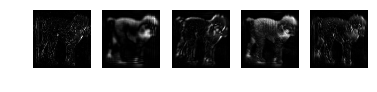

In [9]:
fig2, ax = plt.subplots(1, 5)
for i in range(1,6):
    ax = plt.subplot(1,5,i)
    plt.imshow(op[0, :, :, i+20], cmap = plt.cm.gray)
    plt.axis('off')

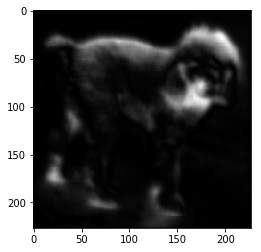

In [10]:
plt.imshow(conv[0,:,:,22],cmap = plt.cm.gray)

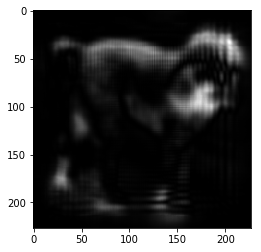

In [11]:
plt.imshow(op[0,:,:,22],cmap = plt.cm.gray)

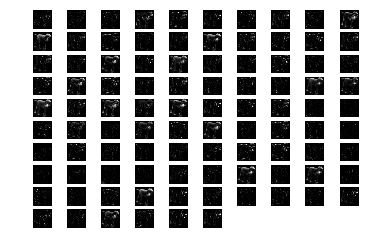

In [12]:
fig, ax = plt.subplots(10, 10)
ax[-1,-1].axis('off')
ax[-1,-2].axis('off')
ax[-1,-3].axis('off')
ax[-1,-4].axis('off')
for i in range(1,97):
    ax = plt.subplot(10,10,i)
    plt.imshow((conv[0, :, :, i-1]),cmap = plt.cm.gray)
    plt.axis('off')

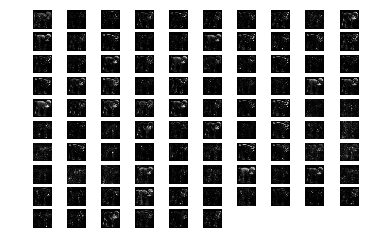

In [13]:
fig, ax = plt.subplots(10, 10)
ax[-1,-1].axis('off')
ax[-1,-2].axis('off')
ax[-1,-3].axis('off')
ax[-1,-4].axis('off')
for i in range(1,97):
    ax = plt.subplot(10,10,i)
    plt.imshow((op[0, :, :, i-1]),cmap = plt.cm.gray)
    plt.axis('off')